In [1]:
from Bio.PDB import *
from Bio.PDB.DSSP import DSSP
from Bio.PDB.DSSP import dssp_dict_from_pdb_file
from Bio import SeqIO

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy.linalg as linalg
from scipy import sparse
from snf import *

def getUnweightedLaplacianEigsDense(W):
    D = sparse.dia_matrix((W.sum(1).flatten(), 0), W.shape).toarray()
    L = D - W
    try:
        _, v = linalg.eigh(L)
    except:
        return np.zeros_like(W)
    return v

def get_csm(X, Y):
    if len(X.shape) == 1:
        X = X[:, None]
    if len(Y.shape) == 1:
        Y = Y[:, None]
    C = np.sum(X**2, 1)[:, None] + np.sum(Y**2, 1)[None, :] - 2*X.dot(Y.T)
    C[C < 0] = 0
    return np.sqrt(C)


def csm_to_binary(D, kappa):
    N = D.shape[0]
    M = D.shape[1]
    if kappa == 0:
        return np.ones_like(D)
    elif kappa < 1:
        NNeighbs = int(np.round(kappa*M))
    else:
        NNeighbs = kappa
    J = np.argpartition(D, NNeighbs, 1)[:, 0:NNeighbs]
    I = np.tile(np.arange(N)[:, None], (1, NNeighbs))
    V = np.ones(I.size)
    [I, J] = [I.flatten(), J.flatten()]
    ret = sparse.coo_matrix((V, (I, J)), shape=(N, M), dtype=np.uint8)
    return ret.toarray()

def csm_to_binary_mutual(D, kappa):
    return csm_to_binary(D, kappa)*(csm_to_binary(D.T, kappa).T)

def sliding_window(dist, win):
    N = D.shape[0]
    dist_stack = np.zeros((N-win+1, N-win+1))
    for i in range(0, win):
        dist_stack += dist[i:i+N-win+1, i:i+N-win+1]
    for i in range(N-win+1):
        dist_stack[i, i] = 0
    return dist_stack

In [2]:

protid = "6909_T154-R1"

parser = PDBParser()
structure = parser.get_structure(protid, "pdb/%s.pdb"%protid)

foundChain = False
for model in structure:
    for chain in model:
        if chain.id == 'A':
            foundChain = True
            break
    if foundChain:
        break

In [7]:
alpha_carbons = []
for atom in chain.get_atoms():
    if atom.id == 'CA':
        alpha_carbons.append(np.array(list(atom.get_vector())))
X = np.array(alpha_carbons)
np.savetxt('csv/%s.csv'%protid, X, delimiter=',')        

In [4]:
dssp = DSSP(model, "pdb/%s.pdb"%protid)

In [5]:
beta = []
for key in list(dssp.keys()):
    if dssp[key][2] == 'E':
        beta.append(dssp[key][0])
print(beta)

[10, 11, 12, 13, 21, 22, 33, 34, 35, 36, 44, 45, 58, 59, 60, 82, 83, 84, 105, 106, 107, 131, 132, 133, 134, 135, 136, 155, 156, 157, 158, 159, 160, 161, 164, 165, 166, 167, 168, 169, 170, 171, 180, 181, 182, 183, 184, 187, 188, 189, 190, 191, 192, 193, 194, 222, 223, 224, 225, 226, 245, 246, 247, 248, 249, 282, 283, 284, 285, 286, 306, 307, 308, 309, 310]


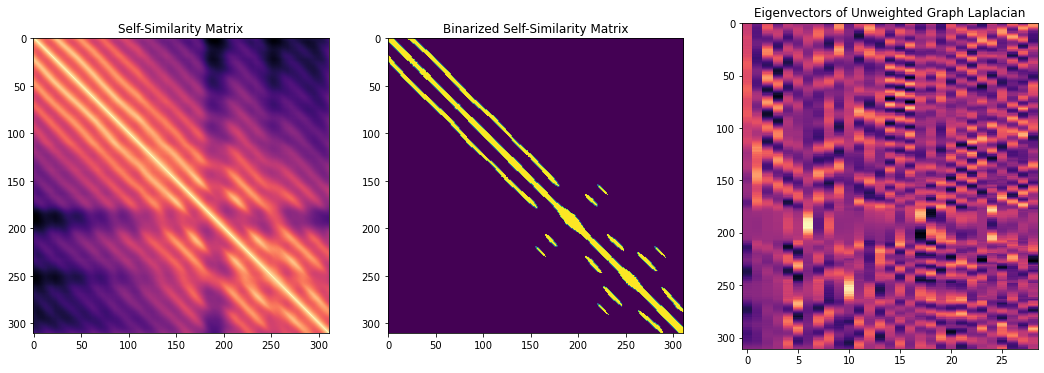

In [8]:
if __name__ == '__main__':
    fin = open("csv/%s.csv"%protid)
    X = [[float(f) for f in line.split(",")] for line in fin.readlines()]
    X = np.array(X)
    D = get_csm(X, X)
    # Clean up the matrix a bit by doing a sliding window of length roughly the period
    period = 25
    D = sliding_window(D, period)
    # Clean up the matrix even more by binarizing it with nearest neighbors
    B = csm_to_binary_mutual(D, 20)
    #B = B[0:400, 0:400]
    v = getUnweightedLaplacianEigsDense(1-B)

    plt.figure(figsize=(18, 6))
    plt.subplot(131)
    plt.imshow(D, cmap='magma_r')
    plt.title("Self-Similarity Matrix")
    plt.subplot(132)
    plt.imshow(B)
    plt.title("Binarized Self-Similarity Matrix")
    plt.subplot(133)
    plt.imshow(v[:, 0:29], aspect='auto', cmap='magma_r', interpolation='none')
    plt.title("Eigenvectors of Unweighted Graph Laplacian")
    plt.show()






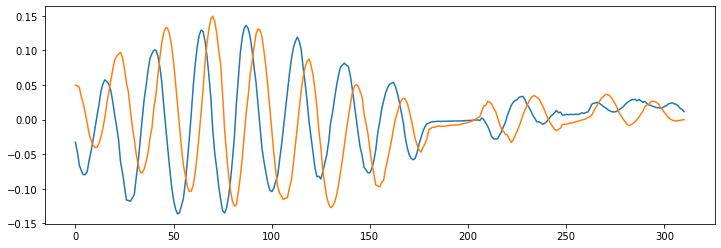

In [11]:
# for LRRpred files
protid = "6909_T154-R1"
clade = 'Int15156_259_362_R_156_181_R_59'

for record in SeqIO.parse('orthogroup_LRR/%s-LRR.fa'%clade, 'fasta'):
    if record.id.startswith(protid):    
        LRR_start = int(record.name.split('|')[1])
        print(LRR_start)
        break
    

481


In [12]:
f = open("LRRPredictor/athaliana_panNLRome_lrrpred.txt", "r")
startrpred = []
for line in f:
        if line.split()[0] == protid:
            startrpred.append(int(line.split()[1])-LRR_start)    
f.close()

In [13]:
startrpred

[30, 55, 79, 102, 125, 154, 177, 219, 242, 279, 303]

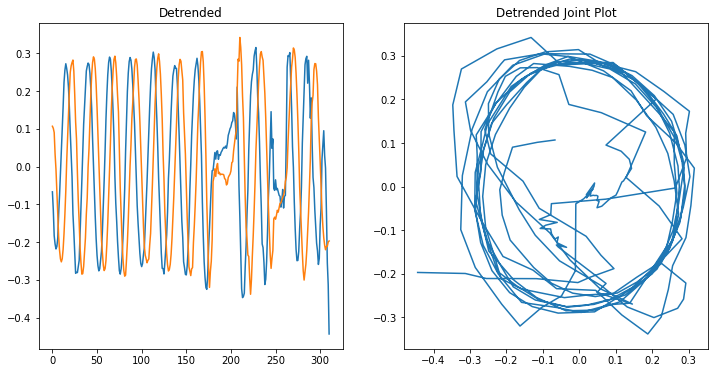

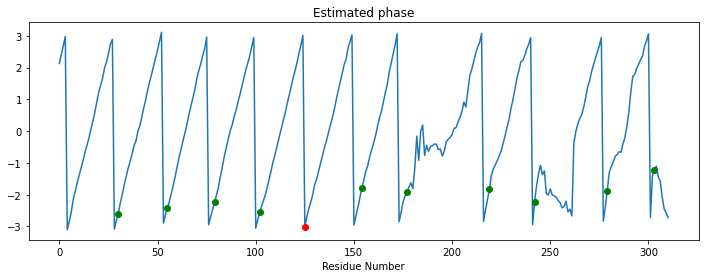

In [16]:
# I can see the signal in the 5th and 6th eigenvectors
# but it needs to be demodulated
plt.figure(figsize=(12, 4))
s = v[:,2]
c = v[:, 3]
plt.plot(s)
plt.plot(c)
plt.show()
from daps import *
# Detrend with daps
sf = detrend_timeseries(s, period)
cf = detrend_timeseries(c, period)

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(sf)
plt.plot(cf)
plt.title("Detrended")
plt.subplot(122)
plt.title("Detrended Joint Plot")
plt.plot(sf, cf)
plt.show()


# Extract the final phase and plot
theta = np.arctan2(cf, sf)
plt.figure(figsize=(12, 4))
cutoff = len(theta)
plt.plot(theta[:cutoff])

for res in startrpred:
    if res < cutoff:
        if np.abs(theta[res]+2)< 1:
            plt.plot(res, theta[res], 'bo', color='green')
        else:
            plt.plot(res, theta[res], 'bo', color='red')                  

plt.title("Estimated phase")
plt.xlabel("Residue Number")



plt.show()

In [50]:
protid = '7crb'

parser = PDBParser()
structure = parser.get_structure(protid, "pdb/%s.pdb"%protid)

for model in structure:
    for chain in model:
        if chain.id == 'A':
            break

In [51]:
f = open("attr/%s_theta.txt"%protid, "w")
f.write("attribute: position\n")
f.write("recipient: residues\n")
for i in range(1, len(chain)+1):
    if i-1 < len(theta):
        f.write("\t" + ":" + str(i) + "\t" + str(theta[i-1]) + "\n")
    else:
        f.write("\t" + ":" + str(i) + "\t" + str(0) + "\n")
f.close()

In [54]:
len(theta)

590